# **Import Libraries & Data Loading**

https://www.kaggle.com/code/ucupsedaya/analisis-sentimen-gojek-v4-8-random-forest/notebook

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re # if u want to learn regex [https://regex101.com/]
import string
import random # Random number generators - Library for generating random numbers, selecting random elements, shuffling sequences, etc.
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option("display.max_columns", None)
# pd.set_option("display.max_row", None)

In [2]:
import nltk # Natural Language Toolkit - Library for natural language processing (NLP) tasks such as tokenization, stemming, tagging, parsing, and more.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm # A Fast, Extensible Progress Bar - Library for creating progress bars to monitor the progress of iterations or tasks.
from nltk.stem import WordNetLemmatizer, PorterStemmer

from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, GlobalMaxPool1D, BatchNormalization, Dropout, GRU, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

import keras
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, # Precision score - Metric for evaluating classification models, measuring the ratio of correctly predicted positive observations to the total predicted positives.
    recall_score, # Recall score - Metric for evaluating classification models, measuring the ratio of correctly predicted positive observations to the total actual positives.
    f1_score, # F1 score - Harmonic mean of precision and recall, a metric for evaluating classification models.
    classification_report, # Classification report - Summary of the precision, recall, F1 score, and support for each class in a classification problem.
    accuracy_score # Accuracy score - Metric for evaluating classification models, measuring the proportion of correct predictions to the total number of predictions.
)

In [3]:
nltk.download(['stopwords', 'punkt', 'wordnet'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
def check_duplicates(dataframe):
    print("Duplicate Values (Top 10):")
    duplicate_values = dataframe[dataframe.duplicated()]
    print(f"Number of Duplicate Rows: {duplicate_values.shape[0]}")
    display(duplicate_values.head(10))

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

def basic_data_info(dataframe):
    print("Data Preview:")
    print("---------------------------")
    display(dataframe.head())

    print("\nGeneral Info:")
    print("---------------------------")
    print(dataframe.info())

    print("\nDescriptive Statistics:")
    print("---------------------------")
    display(dataframe.describe().T)

kaggle datasets download -d ucupsedaya/gojek-app-reviews-bahasa-indonesia

In [5]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Word Embedding untuk NLP/"

In [6]:
df = pd.read_csv(mainPath + "Dataset/GojekAppReviewV4.0.0-V4.9.3_Cleaned.csv")

# **Simple explore the data**

In [7]:
check_duplicates(df)

Duplicate Values (Top 10):
Number of Duplicate Rows: 0


,userName,content,score,at,appVersion


In [8]:
missing_data(df)

,Total,Percent
content,2,0.000889
userName,0,0.000000
score,0,0.000000
at,0,0.000000
appVersion,0,0.000000


In [9]:
basic_data_info(df)

Data Preview:
---------------------------


,userName,content,score,at,appVersion
0,Yuga Edit,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3
1,ff burik,Lambat sekali sekarang ini bosssku apk gojek g...,3,2021-11-30 15:40:38,4.9.3
2,Anisa Suci Rahmayuliani,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3
3,naoki yakuza,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3
4,Trio Sugianto,Mantap,5,2022-01-15 10:05:27,4.9.3



General Info:
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225002 entries, 0 to 225001
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userName    225002 non-null  object
 1   content     225000 non-null  object
 2   score       225002 non-null  int64 
 3   at          225002 non-null  object
 4   appVersion  225002 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.6+ MB
None

Descriptive Statistics:
---------------------------


,count,mean,std,min,25%,50%,75%,max
score,225002.0,3.928996,1.630551,1.0,3.0,5.0,5.0,5.0


# Processing Data

In [10]:
sum(df['appVersion'].str.startswith("4.8"))

8091

In [11]:
# ambil kolom yg dibutuhkan
df = df[df['appVersion'].str.startswith("4.8")]
df = df.loc[:, ['userName', 'content', 'score']]

df.head()

,userName,content,score
133,Abu karim aljabbar Mkatiksaidi,Ramah banget,5
134,Fathan Mubina,Setelah update kok nggak bisa dibuka,4
135,Nyauw Jin Fie,Good,5
136,Tanaka Kun,Good,5
137,Anton S.,Sangat membantu,5


## tokenization

In [12]:
# hapus duplikasi
df = df.dropna(subset=['content']).drop_duplicates()

# stopwords
stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg", "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh"]
df['content'] = df['content'].apply(lambda x: [word.lower() for word in word_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)])

# normalisasi teks
df['content'] = df['content'].apply(lambda x: ' '.join(x))

df.head()

,userName,content,score
133,Abu karim aljabbar Mkatiksaidi,ramah banget,5
134,Fathan Mubina,update nggak dibuka,4
135,Nyauw Jin Fie,good,5
136,Tanaka Kun,good,5
137,Anton S.,membantu,5


In [13]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.8 MB/s eta 0:00:00


In [14]:
# stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stemmer = StemmerFactory().create_stemmer()
df['content'] = df['content'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

df.head(5)

,userName,content,score
133,Abu karim aljabbar Mkatiksaidi,ramah banget,5
134,Fathan Mubina,update nggak buka,4
135,Nyauw Jin Fie,good,5
136,Tanaka Kun,good,5
137,Anton S.,bantu,5


## labelling

In [16]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [17]:
# labelling
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

additional_lexicon_id = {
    'kecewa': -0.4,
    'rugi': -1,
    'buruk': -0.6,
    'jelek': -0.6,
    'lelet': -0.7,
    'gagal': -0.5,
    'parah': -0.6,
    'mahal': -0.3,
    'tolong': -0.1,
    'hilang': -0.3,
    'gajelas': -0.3,
    'gj': -0.3,
    'promo': 0.6,
    'kadang': -0.1,
    'maling': -0.5,
    'ganggu': 0.3,
    'sedot': -0.5,
    'bagus': 0.5,
    'pulsa': 0,
    'potong': -1,
    'baik': 0.5,
    'kntl': -1,
    'ngelag': -0.8,
    'salah': -0.5,
    'bintang': 0,
    'benerin': -0.4,
    'lambat': -0.8,
    'siput': -0.4,
    'mati': -0.7,
    'minimal': -0.3,
    'susah': -0.6,
    'nagih': -0.6,
    'capek': -0.7,
    'kacau': -0.3,
    'tagih': -0.3,
    'mantap': 1,
    'puas': 0.9,
    'sampah': -0.5,
    'sulit': -0.6,
    'aneh': -0.4,
}

analyzer.lexicon.update(additional_lexicon_id)

df['sentimen'] = df['content'].apply(lambda x: 'Positif' if analyzer.polarity_scores(x)['compound'] > 0 else ('Negatif' if analyzer.polarity_scores(x)['compound'] < 0 else 'Netral'))

df

,userName,content,score,sentimen
133,Abu karim aljabbar Mkatiksaidi,ramah banget,5,Netral
134,Fathan Mubina,update nggak buka,4,Netral
135,Nyauw Jin Fie,good,5,Positif
136,Tanaka Kun,good,5,Positif
137,Anton S.,bantu,5,Netral
...,...,...,...,...
8219,Malik Azis,gopay mantap,5,Positif
8220,Zunus,buka aplnya hapus download beberpa kali restar...,1,Netral
8221,Mutiara Purnama,bye bye gojek alih ijo lah mantapp,1,Netral
8222,Melanie Anggi,fitur gomed ya,5,Netral


In [77]:
# df.to_csv(mainPath + "Dataset/CleanData.csv")
df = pd.read_csv(mainPath + "Dataset/CleanData.csv").drop(columns = "Unnamed: 0").dropna()

In [78]:
df

,userName,content,score,sentimen
0,Abu karim aljabbar Mkatiksaidi,ramah banget,5,Netral
1,Fathan Mubina,update nggak buka,4,Netral
2,Nyauw Jin Fie,good,5,Positif
3,Tanaka Kun,good,5,Positif
4,Anton S.,bantu,5,Netral
...,...,...,...,...
8085,Malik Azis,gopay mantap,5,Positif
8086,Zunus,buka aplnya hapus download beberpa kali restar...,1,Netral
8087,Mutiara Purnama,bye bye gojek alih ijo lah mantapp,1,Netral
8088,Melanie Anggi,fitur gomed ya,5,Netral


## # TF-IDF

In [79]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])

In [80]:
# Simpan objek tfidf_vectorizer
import pickle

# Misalnya, disimpan dengan nama 'tfidf_vectorizer.pkl'
with open(mainPath + 'Gojek_tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Ketika akan melakukan prediksi pada data baru
# Load kembali tfidf_vectorizer
with open(mainPath + 'Gojek_tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

In [30]:
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

# Visualisasi Data based on Sentimentnya

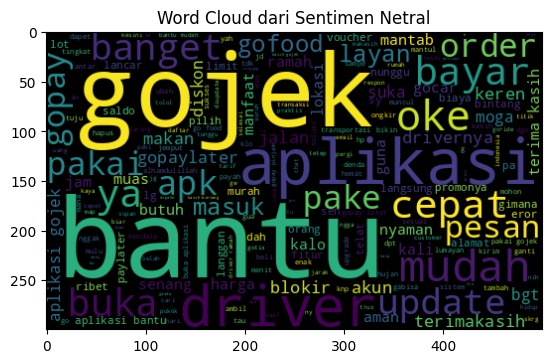

In [31]:
df_netral = df[df['sentimen'] == 'Netral']
all_words_netral = ' '.join([twts for twts in df_netral['content']])
wordcloud_netral = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_netral)

plt.imshow(wordcloud_netral, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Netral')
plt.show()

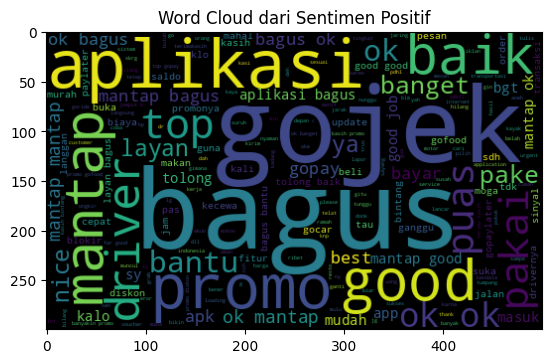

In [32]:
df_positif = df[df['sentimen'] == 'Positif']
all_words_positif = ' '.join([twts for twts in df_positif['content']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Positif')
plt.show()

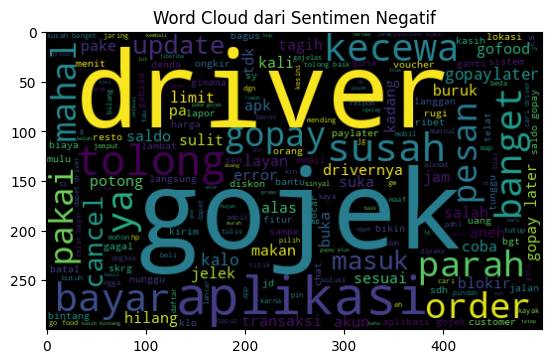

In [33]:
df_negatif = df[df['sentimen'] == 'Negatif']
all_words_negatif = ' '.join([twts for twts in df_negatif['content']])
wordcloud_negatif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_negatif)

plt.imshow(wordcloud_negatif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Negatif')
plt.show()

# Distribusi Target

In [34]:
temp = df.groupby('sentimen').count()['content'].reset_index().sort_values(by='content',ascending=False)
temp.style.background_gradient(cmap='inferno_r')

,sentimen,content
1,Netral,3852
2,Positif,2541
0,Negatif,1562


In [35]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentimen,
    values = temp.content,
    title = {"position": "top center", "text": "Funnel-Chart dari Distribusi target"}
    ))
fig.show()

# Splitting Data

In [37]:
# Data Splitting into Train, Test, Val Dataset

'''
Train set: 80% of initial data (X_train, y_train)
Test set: 20% of initial data (X_test, y_test)
'''

# Reset indeks semua data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentimen'],
                                                    test_size=0.2,  # 20% untuk test + val
                                                    random_state=42,
                                                    stratify=df['sentimen'])

print('Val Size   : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Val Size   :  (6364, 6961)
Test Size  :  (1591, 6961)


In [38]:
# Define the one-hot encoding function
def one_hot_encoding(y):
    return to_categorical(y)

In [39]:
ohe_transformer = FunctionTransformer(one_hot_encoding)

In [42]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert the encoded labels to one-hot encoded format
y_train_ohe = to_categorical(y_train_encoded)
y_test_ohe = to_categorical(y_test_encoded)

In [43]:
# Now you have one-hot encoded labels
print(y_train_ohe)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [44]:
y_train_ohe.shape, X_train.shape

((6364, 3), (6364, 6961))

# Modeling

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [46]:
# init parameters
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

In [47]:
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [48]:
# print best param
print("\nBest Parameters for Random Forest:", rf_model.best_params_)


Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


In [50]:
# evaluasi model
from sklearn.metrics import classification_report, confusion_matrix

y_pred_rf = rf_model.best_estimator_.predict(X_test)

print("\n\nClassification Report for Random Forest (Tuned):")
print(classification_report(y_test, y_pred_rf))



Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

     Negatif       0.93      0.92      0.92       312
      Netral       0.95      0.99      0.97       771
     Positif       0.98      0.92      0.95       508

    accuracy                           0.95      1591
   macro avg       0.95      0.94      0.95      1591
weighted avg       0.95      0.95      0.95      1591



In [51]:
# Generate confusion matrix
confusion_matrix_RF = confusion_matrix(y_test, y_pred_rf)

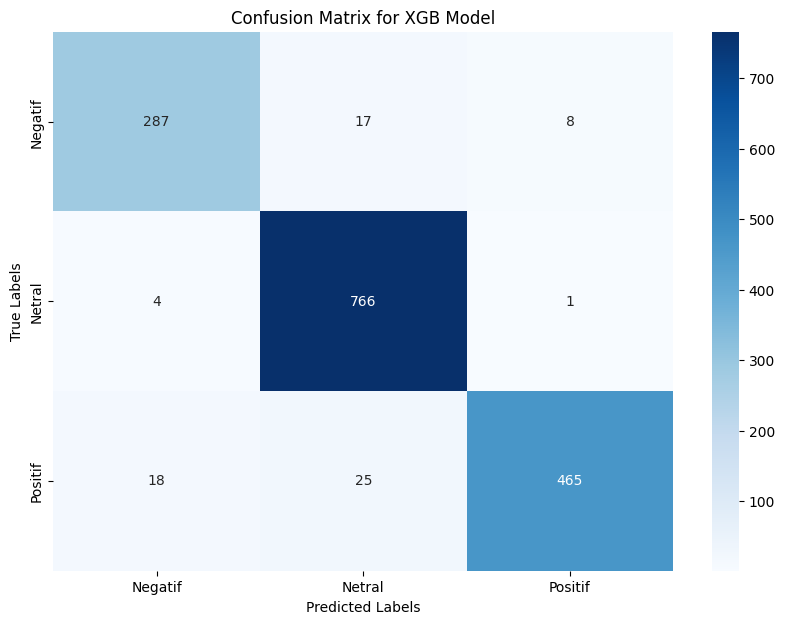

In [52]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_RF, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGB Model')
plt.show()

# Model Inference

In [68]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# from sklearn.feature_extraction.text import TfidfVectorizer

# # stopwords
# stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg", "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh"]
# sentences_df['Kalimat'] = sentences_df['Kalimat'].apply(lambda x: [word.lower() for word in word_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)])
# # normalisasi teks
# sentences_df['Kalimat'] = sentences_df['Kalimat'].apply(lambda x: ' '.join(x))
# # stemming
# stemmer = StemmerFactory().create_stemmer()
# sentences_df['Kalimat'] = sentences_df['Kalimat'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
# # TF-IDF
# tfidf_vectorizer = TfidfVectorizer()
# X_tfidf = tfidf_vectorizer.fit_transform(sentences_df['Kalimat'])

In [82]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(data_df):
    # stopwords
    stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg", "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh"]

    # lowercase, tokenization, dan menghapus stopwords
    data_df['Kalimat'] = data_df['Kalimat'].apply(lambda x: [word.lower() for word in word_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)])

    # normalisasi teks
    data_df['Kalimat'] = data_df['Kalimat'].apply(lambda x: ' '.join(x))

    # stemming
    stemmer = StemmerFactory().create_stemmer()
    data_df['Kalimat'] = data_df['Kalimat'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

    return data_df

def create_tfidf_features(data_df):
    # Preprocess text
    preprocessed_df = preprocess_text(data_df.copy())

    # Gunakan tfidf_vectorizer untuk melakukan transformasi pada data teks baru
    X_tfidf_features_new = tfidf_vectorizer.transform(sentences_df['Kalimat'])

    return X_tfidf_features_new

In [83]:
data_sentences = ["aplikasinya sangat bagus sangat membantu saya bekerja",
                   "aplikasinya sangat jelek sekali membingungkan",
                   "aplikasinya bagus ko mengantarkan saya sekolah setiap hari"]

# Membuat DataFrame dari data kalimat
sentences_df = pd.DataFrame(data_sentences, columns=['Kalimat'])

In [84]:
X_tfidf_features = create_tfidf_features(sentences_df)

In [85]:
X_tfidf_features

<3x6961 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [87]:
# Lakukan prediksi
y_pred_rf_new = rf_model.best_estimator_.predict(X_tfidf_features)

In [91]:
sentences_df['label'] = y_pred_rf_new

In [93]:
sentences_df

,Kalimat,label
0,aplikasinya sangat bagus sangat membantu saya ...,Positif
1,aplikasinya sangat jelek sekali membingungkan,Negatif
2,aplikasinya bagus ko mengantarkan saya sekolah...,Positif
